In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip ./glove.6B.zip
!wget http://www.manythings.org/anki/spa-eng.zip
!unzip ./spa-eng.zip

--2022-07-27 10:07:50--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2022-07-27 10:07:50--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2022-07-27 10:07:51--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [ ]:
from tensorflow import keras
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import random

In [ ]:

latent_dim=256
emb_dim=100
max_vocabs=20000

data=open("spa.txt")

input_texts=[]
target_input=[]
target_output=[]
for line in data:

  if len(input_texts)==10000:
    break
  if "\t" not in line:
    continue  
   
  input_text,temp,_=line.lower().split("\t")  
  if input_text!="" and temp!="" :
    input_texts.append(input_text)
    target_input.append("<sos> "+temp)
    target_output.append(temp+" <eos>")

In [ ]:
tokenizer_for_input=keras.preprocessing.text.Tokenizer(num_words=max_vocabs)
tokenizer_for_input.fit_on_texts(input_texts)
input_sequence=tokenizer_for_input.texts_to_sequences(input_texts)

In [ ]:


tokenizer_for_output=keras.preprocessing.text.Tokenizer(num_words=max_vocabs,filters="")
tokenizer_for_output.fit_on_texts(target_input+target_output)
target_input_sequence=tokenizer_for_output.texts_to_sequences(target_input)
target_output_sequence=tokenizer_for_output.texts_to_sequences(target_output)

In [ ]:
word2index_target=tokenizer_for_output.word_index

In [ ]:

max_input_sequance_len=max(len(s) for s in input_sequence)
max_output_sequance_len=max(len(s) for s in target_input_sequence)

In [ ]:
input_sequence=keras.preprocessing.sequence.pad_sequences(input_sequence,maxlen=max_input_sequance_len,padding="post")
target_input_sequence=keras.preprocessing.sequence.pad_sequences(target_input_sequence,maxlen=max_output_sequance_len,padding="post")
target_output_sequence=keras.preprocessing.sequence.pad_sequences(target_output_sequence,maxlen=max_output_sequance_len,padding="post")

In [ ]:
num_word=min(len(word2index_target)+1,max_vocabs)
target=np.zeros((len(target_input),max_output_sequance_len,len(word2index_target)+1),dtype="float32")
for i,j in enumerate(target_output_sequence) :
  for k,l in enumerate(j):
    # if l>0:
         target[i,k,l]=1.0

In [ ]:
word2vec={}
f=open("./glove.6B."+str(emb_dim)+"d.txt")    
for line in f:
        temp=line.split()
        word=temp[0]
        vec=np.asarray(temp[1:],dtype="float32")
        word2vec[word]=vec

In [ ]:
embedding_matrix=np.zeros((num_word,emb_dim))
for word,i in word2index_target.items():
  if i<max_vocabs:
    embedding_vec=word2vec.get(word)
    if  embedding_vec is not None:
        embedding_matrix[i]=embedding_vec

In [ ]:

def softmax_over_time(x):
  assert(keras.backend.ndim(x)>2)
  e=keras.backend.exp(x-keras.backend.max(x,axis=1,keepdims=True))
  s=keras.backend.sum(e,axis=1,keepdims=True)
  return e/s

In [ ]:
input_embedding_layer=keras.layers.Embedding(num_word,emb_dim,weights=[embedding_matrix]
                                        ,input_length=max_input_sequance_len)

In [ ]:
encoder_input=keras.layers.Input(shape=(max_input_sequance_len,))
the_output_of_input_embedding_layer=input_embedding_layer(encoder_input)
encoder_lstm1=keras.layers.Bidirectional( keras.layers.LSTM(latent_dim, return_sequences=True,dropout=0.4
                                                            ,recurrent_dropout=0.4))
encoder_output=encoder_lstm1(the_output_of_input_embedding_layer)
# encoder_output=keras.layers.BatchNormalization(momentum=0.8)(encoder_output)

In [ ]:
decoder_input=keras.layers.Input(shape=(max_output_sequance_len,))
decoder_embedding_layer=keras.layers.Embedding(len(word2index_target)+1,emb_dim)
the_output_of_decoder_embedding_layer=decoder_embedding_layer(decoder_input)
# attn=keras.layers.Attention()
# attn=keras.layers.MultiHeadAttention(num_heads=5,key_dim=2)
attn_repeat_layer=keras.layers.RepeatVector(max_input_sequance_len)
# attn_avg=keras.layers.AveragePooling1D(pool_size=3)
attn_concat_layer=keras.layers.Concatenate(axis=-1)
attn_dense_layer1=keras.layers.Dense(10,activation="tanh")
attn_dense_layer2=keras.layers.Dense(1,activation=softmax_over_time)
attn_dot=keras.layers.Dot(axes=1)

In [ ]:
def one_step_attention(h,s):
  s=attn_repeat_layer(s)

  x=attn_concat_layer([h,s])
  x=attn_dense_layer1(x)
  # # x1=attn_dense_layer1(h)
  
  alphas=attn_dense_layer2(x)
  
  context=attn_dot([alphas,h])
  # context=attn([s,h,s])
 
  # context=attn([s,h])
  # context=attn_dot([context,h])
  return context

In [ ]:
decoder_lstm1=keras.layers.LSTM(latent_dim,return_state=True,dropout=0.4
                                                            ,recurrent_dropout=0.4)

# decoder_dense1=keras.layers.Dense(4096,activation="tanh") 
# decoder_dense2=keras.layers.Dense(4096*2,activation="sigmoid") 
# decoder_Batch=keras.layers.BatchNormalization(momentum=0.8)
decoder_dense=keras.layers.Dense(len(word2index_target)+1,activation="softmax")
initial_h=keras.layers.Input(shape=(latent_dim,),name="s0")
initial_c=keras.layers.Input(shape=(latent_dim,),name="c0")
decoder_concat_layer=keras.layers.Concatenate(axis=-1)
s=initial_h
c=initial_c
output=[]
# dec_repeat_layer=keras.layers.RepeatVector(max_output_sequance_len)
for i in range(max_output_sequance_len):
  context=one_step_attention(encoder_output,s)
  selector=keras.layers.Lambda(lambda x: x[:,i:i+1])
  xt=selector(the_output_of_decoder_embedding_layer)
  decoder_lstm_input=decoder_concat_layer([context,xt])
  o,s,c=decoder_lstm1( decoder_lstm_input,initial_state=[s,c])
  # o=decoder_dense1(o)
  # o=decoder_Batch(o)
  decoder_output=decoder_dense(o)
  output.append(decoder_output)
def stack_transpose(x):
  x=keras.backend.stack(x)
  x=keras.backend.permute_dimensions(x,pattern=(1,0,2))
  return x
stack_and_transpose=keras.layers.Lambda(stack_transpose)
output=stack_and_transpose(output) 


In [ ]:

model=keras.Model([encoder_input,decoder_input,initial_h,initial_c],output) 



In [ ]:
model.compile(optimizer="adam",loss=keras.losses.CategoricalCrossentropy(),metrics=["accuracy"])

In [ ]:
z=np.zeros((len(input_sequence),latent_dim))
history=model.fit([input_sequence,target_input_sequence,z,z]
          ,target,batch_size=64,epochs=50,validation_split=0.2,
          callbacks=[keras.callbacks.EarlyStopping(monitor="val_loss",patience=2,restore_best_weights=True)],use_multiprocessing=True)

In [ ]:
history=history.history

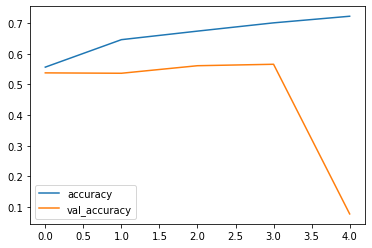

In [ ]:
plt.plot(history["accuracy"],label="accuracy")
plt.plot(history["val_accuracy"],label="val_accuracy")
plt.legend()
plt.show()

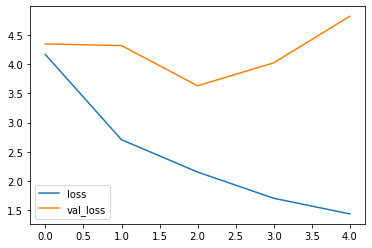

In [ ]:
plt.plot(history["loss"],label="loss")
plt.plot(history["val_loss"],label="val_loss")
plt.legend()
plt.show()

In [ ]:
encoder_model=keras.Model(encoder_input,encoder_output)

In [ ]:
decoder_input_single_word=keras.layers.Input(shape=(1,))
encoder_output_as_input=keras.layers.Input(shape=(max_input_sequance_len,latent_dim*2))
the_output_of_decoder_embedding_layer=decoder_embedding_layer(decoder_input_single_word)
context=one_step_attention(encoder_output_as_input,initial_h)
decoder_lstm_input=decoder_concat_layer([context,the_output_of_decoder_embedding_layer])
o,s,c=decoder_lstm1( decoder_lstm_input,initial_state=[initial_h,initial_c])
decoder_output=decoder_dense(o)
decoder_model=keras.Model([decoder_input_single_word,encoder_output_as_input,initial_h,initial_c],[decoder_output,s,c])

In [ ]:
j=random.randint(0, len(input_sequence)-1)
en_out=encoder_model.predict(input_sequence[j:j+1])
print("orginal: "+input_texts[j])
de_in=np.asarray([[word2index_target["<sos>"]]])
z1=np.zeros(shape=(1,latent_dim))
s=z1
c=z1
gen_sen=""
for i in range(max_output_sequance_len):
  o,s,c=decoder_model.predict([de_in,en_out,s,c])
  idx=np.argmax(o[0,:])
  word=tokenizer_for_output.index_word[idx]  
  de_in=np.asarray([[idx]])
  if max_output_sequance_len-1==i:
    print("done before finding eos")
    print(gen_sen)
  if word=="<eos>":
    
    print(gen_sen)
    break
  else:
    if gen_sen=="":
      gen_sen+=word
    else:
      gen_sen+=" "+word  

orginal: cuff him.
espósale.
